In [1]:
import numpy as np
import torch
import torchvision as tvn
import matplotlib.pyplot as plt
import sklearn.metrics as skm

In [2]:
nn_params = {'nodes_layer_0': 1024,        
             'nodes_layer_1': 512,  
             'nodes_layer_2': 256,
             'nodes_layer_3': 128
             }

prop_params = {'ReLU_1': 0.2,               
               'ReLU_2': 0.2,
               'ReLU_3': 0.2,
               'ReLU_4': 0.2,
               'Drop_1': 0.25,
               'Drop_2': 0.25,
               'Drop_3': 0.25,
               'Drop_4': 0.25
               }

training_conditions = {'n_epochs': 1,                  
                       'batch_size_train': 64,
                       'batch_size_test': 1000,
                       'learning_rate': 0.01,
                       'momentum': 0.05,
                       'log_interval': 10,
                       'rdm_seed': 1
                       }

In [3]:
torch.manual_seed(training_conditions['rdm_seed'])

In [4]:
train_loader = torch.utils.data.DataLoader(tvn.datasets.MNIST('/files/', train = True, download = True,
                                                            transform = tvn.transforms.Compose([tvn.transforms.ToTensor(),
                                                            tvn.transforms.Normalize((0.1307,), (0.3081,))])),batch_size=training_conditions['batch_size_train'], shuffle=True)

test_loader = torch.utils.data.DataLoader(tvn.datasets.MNIST('/files/', train = False, download = True,
                                                            transform = tvn.transforms.Compose([tvn.transforms.ToTensor(),
                                                            tvn.transforms.Normalize((0.1307,), (0.3081,))])),batch_size=training_conditions['batch_size_test'], shuffle=True)

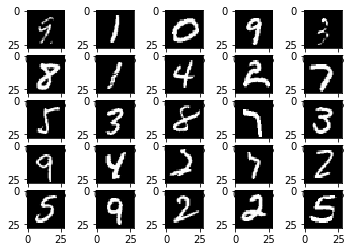

In [6]:
example_group = enumerate(test_loader)
group_index, (group_data, group_truths) = next(example_group)

fig = plt.figure()
for i in range(0,25):
    plt.subplot(5,5,i + 1)
    plt.imshow(group_data[i][0], cmap = 'gray', interpolation = 'none')
plt.show()

In [7]:
class NN(torch.nn.Module):
    def __init__(self,nn_params, prop_params):
        super(NN, self).__init__()
        initial_features = 784
        final_features = 10
        self.hidden_layerin = torch.nn.Sequential(torch.nn.Linear(initial_features,nn_params['nodes_layer_0']),torch.nn.LeakyReLU(prop_params['ReLU_1']),torch.nn.Dropout(prop_params['Drop_1']))
        self.hidden_layer1 = torch.nn.Sequential(torch.nn.Linear(nn_params['nodes_layer_0'],nn_params['nodes_layer_1']),torch.nn.LeakyReLU(prop_params['ReLU_2']),torch.nn.Dropout(prop_params['Drop_2']))
        self.hidden_layer2 = torch.nn.Sequential(torch.nn.Linear(nn_params['nodes_layer_1'],nn_params['nodes_layer_2']),torch.nn.LeakyReLU(prop_params['ReLU_3']),torch.nn.Dropout(prop_params['Drop_3']))
        self.hidden_layer3 = torch.nn.Sequential(torch.nn.Linear(nn_params['nodes_layer_2'],nn_params['nodes_layer_3']),torch.nn.LeakyReLU(prop_params['ReLU_4']),torch.nn.Dropout(prop_params['Drop_4']))
        self.layer_out = torch.nn.Linear(nn_params['nodes_layer_3'],final_features)

    def forward(self, x):
        x = x.view(-1,784)
        x_in = self.hidden_layerin(x)
        x_1 = self.hidden_layer1(x_in)
        x_2 = self.hidden_layer2(x_1)
        x_3 = self.hidden_layer3(x_2)
        x_4 = self.layer_out(x_3)
        x_out = torch.nn.functional.log_softmax(x_4,dim=1)
        return [x_out,x_in,x_1,x_2,x_3]

network = NN(nn_params, prop_params)

In [10]:
optimizer = torch.optim.SGD(network.parameters(), lr= training_conditions['learning_rate'],momentum= training_conditions['momentum'])
loss_function = torch.nn.functional.nll_loss

def train(train_set,loss_func,method,log_interval,epochs):
    network.train() 
    for index, (data, truth) in enumerate(train_set):
        method.zero_grad()
        output = network(data) 
        loss = loss_func(output[0], truth)
        loss.backward()
        method.step()
        if index % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epochs, index * len(data), len(train_set.dataset),
                                                                    100. * index / len(train_set), loss.item()))
    return [output,truth,'training']


def test(test_set,loss_func):
    test_losses = []
    network.eval()
    total_test_loss = 0
    total_correct = 0
    with torch.no_grad():
        for index, (data, truth) in enumerate(test_set):
            output = network(data)
            test_loss = loss_func(output[0], truth, size_average = False)
            total_test_loss += test_loss.item()
            pred = output[0].data.max(1, keepdim = True)[1]
            total_correct += pred.eq(truth.data.view_as(pred)).sum()
    avg_test_loss = total_test_loss / len(test_set.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(avg_test_loss, total_correct, len(test_set.dataset),
            100. * total_correct / len(test_set.dataset)))
    return [output, truth,'testing']

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(training_conditions['n_epochs'] + 1)]

test(test_loader,loss_function)
for epoch in range(1, training_conditions['n_epochs'] + 1): 
    training_data_results = train(train_loader,loss_function,optimizer,training_conditions['log_interval'],1)
    testing_data_results = test(test_loader,loss_function)

C:\Users\Andy Xie\Anaconda3\envs\api-dev\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3022, Accuracy: 1027/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305888
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300384
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.313107
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.294436
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.291478
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.297289
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.288724
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.289662
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.281204
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.294892
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.285150
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.276313
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.277714
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.265767
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.265119
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.292003
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.282774
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.270091
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.268430
Train Epoch: 1 [12160

In [12]:
def layer_visuals(layer_num,data_results,ith):
    if data_results[2] == 'training':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        base = input('Base: \n')
        height = input('Height: \n')
        fig = plt.figure(figsize=(10,2))
        for i in range(ith,ith+5):
            image = chosen_layer[i].view(int(height),int(base))
            for j in range(5):
                plt.subplot(1,5,j + 1)
                plt.imshow(image.detach(), cmap = 'gray', interpolation = 'none')
                plt.xticks([])
                plt.yticks([])
        plt.show()
    elif data_results[2] == 'testing':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        base = input('Base: \n')
        height = input('Height: \n')
        fig = plt.figure(figsize=(10,2))
        for i in range(ith,ith+5):
            image = chosen_layer[i].view(int(height),int(base))
            for j in range(5):
                plt.subplot(1,5,j + 1)
                plt.imshow(image.detach(), cmap = 'gray', interpolation = 'none')
                plt.xticks([])
                plt.yticks([])
        plt.show()

torch.Size([32, 512])
Base: 
32
Height: 
16


C:\Users\Andy Xie\Anaconda3\envs\api-dev\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


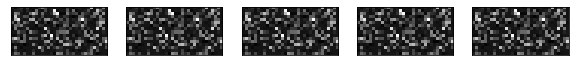

In [14]:
layer_visuals(2,training_data_results,4)

torch.Size([1000, 256])
Base: 
16
Height: 
16


C:\Users\Andy Xie\Anaconda3\envs\api-dev\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


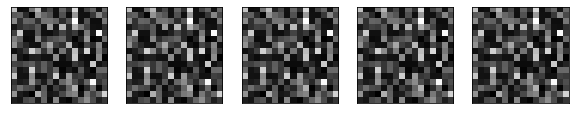

In [15]:
layer_visuals(3,testing_data_results,2)

In [17]:
def layer_loss_analysis(layer_num,data_results,loss_func):
    if data_results[2] == 'training':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        if len(chosen_layer.shape) == 2:
            layer = torch.nn.functional.log_softmax(chosen_layer, dim=1)
            loss = loss_func(layer, data_results[1])
            print('Layer Number: {}, Loss: {:.6f}\n'.format(layer_num, loss)) 
        else:
            print('Invalid')
    if data_results[2] == 'testing':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        if len(chosen_layer.shape) == 2:
            layer = torch.nn.functional.log_softmax(chosen_layer, dim=1)
            loss = loss_func(layer, data_results[1])
            print('Layer Number: {}, Loss: {:.6f}\n'.format(layer_num, loss))
        else:
            print('Invalid')

In [18]:
layer_loss_analysis(2,training_data_results,loss_function)

torch.Size([32, 512])
Layer Number: 2, Loss: 6.504313



In [20]:
layer_loss_analysis(0,testing_data_results,loss_function)

torch.Size([1000, 10])
Layer Number: 0, Loss: 0.551559



In [21]:
classes = [0,1,2,3,4,5,6,7,8,9]

def accuracy_individual_classes(classes,test_set):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    for data in test_set:
        images, labels = data
        outputs = network(images)
        _, predicted = torch.max(outputs[0], 1)
        correct = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    for i in range(len(classes)):
        print('Accuracy of %s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [22]:
accuracy_individual_classes(classes,test_loader)

Accuracy of 0 : 96 %
Accuracy of 1 : 98 %
Accuracy of 2 : 79 %
Accuracy of 3 : 87 %
Accuracy of 4 : 84 %
Accuracy of 5 : 62 %
Accuracy of 6 : 93 %
Accuracy of 7 : 88 %
Accuracy of 8 : 76 %
Accuracy of 9 : 66 %


In [30]:
def saving_textfile(file,pandas_true):
    filename = input('Enter filename: \n')
    directory = input('Enter a directory: \n')
    if pandas_true == False:
        f = open(str(directory)+'\\'+str(filename),'w+')
        for line in file:
            f.writelines(str(list(line.numpy())))
        f.close()
    else:
        file.to_csv(str(directory)+'\\'+str(filename),'w+')

In [24]:
def weights_biases():
    parameters = {}
    for i in network.named_parameters():
        parameters[i[0]] = i[1] 
    specific_parameters = parameters.keys()
    while(True):
        print('The weights and biases of these layers have been identified: \n')
        for j in specific_parameters:
            print(j)
        print('\n')
        wanted_parameter = input('Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. \n')
        print('\n')
        if wanted_parameter == '0':
            break
        elif wanted_parameter == 'E' or wanted_parameter == 'e':
            wanted_parameter = input('Please enter the parameter to export: \n')
            data = parameters[str(wanted_parameter)].detach()
            saving_textfile(data,False)
            break
        elif wanted_parameter[-4:] == 'bias':
            while(True):
                ith_bias_ith_layer, end = input('Enter the bias range: \n').split()
                if end == 'x':
                    break
                else:
                    print('\n')
                    print(parameters[wanted_parameter][int(ith_bias_ith_layer):int(end)].detach())
                    print('\n')
        else:
            ith_node = input('Enter the node number: \n')
            while(True):
                ith_weight_ith_node, end = input('Enter the input weights: \n').split()
                if end == 'x':
                    break
                else:
                    print('\n')
                    print(parameters[wanted_parameter][int(ith_node)][int(ith_weight_ith_node):int(end)].detach())
                    print('\n')
    print('Closed.')

In [25]:
weights_biases()

The weights and biases of these layers have been identified: 

hidden_layerin.0.weight
hidden_layerin.0.bias
hidden_layer1.0.weight
hidden_layer1.0.bias
hidden_layer2.0.weight
hidden_layer2.0.bias
hidden_layer3.0.weight
hidden_layer3.0.bias
layer_out.weight
layer_out.bias


Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. 
hidden_layer1.0.weight


Enter the node number: 
2
Enter the input weights: 
34 45


tensor([ 0.0110, -0.0103,  0.0208, -0.0278, -0.0184,  0.0126, -0.0118, -0.0112,
         0.0273, -0.0101,  0.0133])


Enter the input weights: 
1 12


tensor([-0.0131, -0.0103,  0.0183, -0.0131, -0.0302,  0.0181, -0.0213,  0.0235,
         0.0189,  0.0217,  0.0297])


Enter the input weights: 
0 x
The weights and biases of these layers have been identified: 

hidden_layerin.0.weight
hidden_layerin.0.bias
hidden_layer1.0.weight
hidden_layer1.0.bias
hidden_layer2.0.weight
hidden_layer2.0.bias
hidden_layer3.0.weight
hidden_layer3.0.bias
layer